# Gridded climate data for Vienna
This notebook will
- access gridded climate data over Vienna from GeoSphere Austria (via REST API)
- interpolate (regrid) climate data using ordinary Kriging

Problem: gridded climate data comes in CRS EPSG:3416, and we need to harmonise it with other datasets that are in CRS EPSG:31256. In the image below, we see the maximum daily temperature of 22.04.24 over Wien. The black grid represents the target datacube in EPSG:31256, also the outline of the districts are visible.
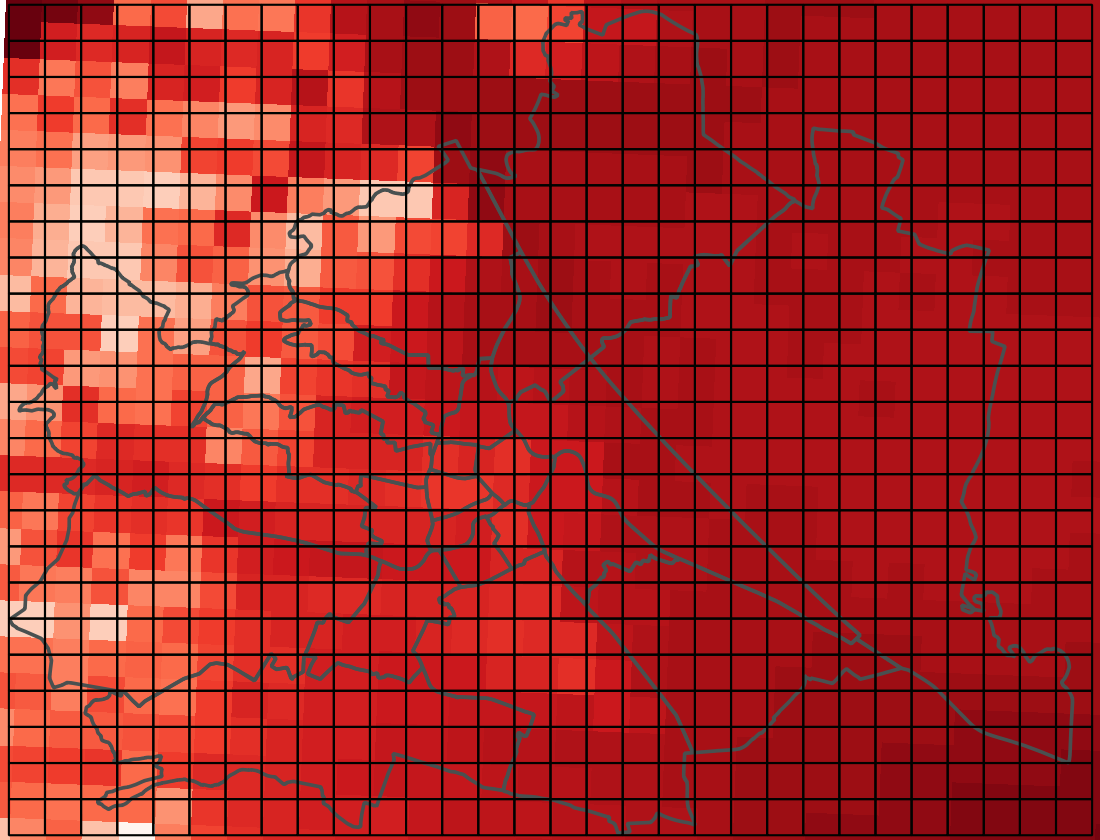

When zooming in, one can see that the climate data does not perfectly align with the target grid. To decide which temperature should be assigned, e.g., to the red cell (one cell=one value), one has to _interpolate_ the temperature of the cells close-by. One popular method to interpolate spatial data is called ordinary Kriging.
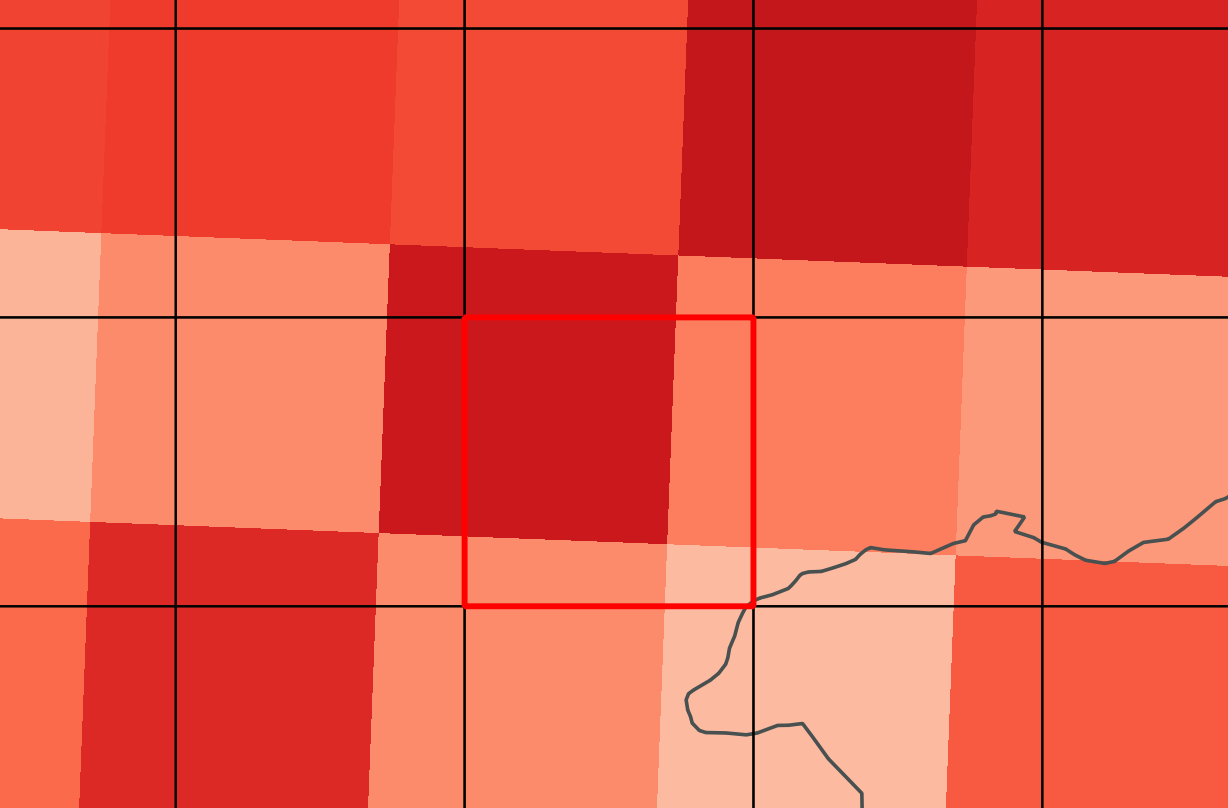 

This notebook shows how to do that.

In [ ]:
import numpy as np
from scipy.spatial.krg import OrdinaryKriging
import fiona
import requests

In [ ]:
def fetch_data_geosphere(endpoint, parameters, bbox, start_time, end_time, output_format):

    params = {"parameters": parameters,
              "bbox": bbox,
              "start": start_time,
              "end": end_time,
              "output_format": output_format}

    response = requests.get(endpoint, params=params)

    if response.status_code == 200:  # OK status code means data is available
        data = response.json()
        print(data)  # Print the list of users
        return data
    else:
        print("Error:", response.status_code)
        return None

def interpolate_grid(source_data, target_grid):
    # source data is geojson 
    x, y, z = zip(*[(feat['x'], feat['y'], feat['z']) for feat in source_data])
    # Create an Ordinary Kriging object
    ok = OrdinaryKriging(x, y, z)
    new_x, new_y = zip(*[(feat['x'], feat['y']) for feat in target_grid])
    new_z = ok.griddata(new_x, new_y)  # Perform interpolation
    # save new_z in shapefile